In [1]:
import pandas as pd
import numpy as np
import datetime
from EvGym import config

save = True

In [2]:
pd.Timedelta(2.333, unit='h')

Timedelta('0 days 02:19:58.800000')

In [3]:
file = "data/data-SDG/0 Generated sample (AC,poisson_fit) Horizon =2015-01-01-to-2015-12-31.csv"
df_sdg = pd.read_csv(file, parse_dates = ["Date"])
df_sdg = df_sdg.drop(["AM_specs", "MMc_specs", "MMe_specs"], axis = 1)
len(df_sdg)
df_sdg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362125 entries, 0 to 362124
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             362125 non-null  datetime64[ns]
 1   Arrival          362125 non-null  float64       
 2   Connected_time   362125 non-null  float64       
 3   Energy_required  362125 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.1 MB


In [4]:
df_sdg["starttime_parking"] = df_sdg["Date"] + pd.to_timedelta(df_sdg["Arrival"], unit='h')
df_sdg["month"] = df_sdg["starttime_parking"].dt.month
df_sdg["day"] = df_sdg["starttime_parking"].dt.day
df_sdg["ts_arr"] = np.floor((df_sdg["starttime_parking"] - config.starttime_min).dt.total_seconds()/ config.timestep)
df_sdg["ts_dep"] = np.ceil(df_sdg["ts_arr"] +  df_sdg["Connected_time"])
#df_sdg["soc_arr"] = np.clip(config.FINAL_SOC - 0.01 -df_sdg["Energy_required"]**config.sdg_pot / config.sdg_norm,
#                             0, config.FINAL_SOC)

# As laxity is crucial, and the SDG data is not very realistic, we will calculate laxity ourselves
df_sdg["laxity"] = np.clip((df_sdg["Connected_time"] * config.sdg_norm)**config.sdg_pot - df_sdg["Connected_time"]*np.random.uniform(0, 0.4, size = len(df_sdg)), 0, df_sdg["Connected_time"])
df_sdg["soc_arr"] = (df_sdg["laxity"] - np.ceil(df_sdg["Connected_time"]))*config.alpha_c * config.eta_c / config.B + config.FINAL_SOC + np.random.uniform(0, 0.1, size = len(df_sdg))
df_sdg["soc_arr"] = np.clip(df_sdg["soc_arr"], 0, config.FINAL_SOC)
df_sdg["laxity"] = np.ceil(df_sdg["Connected_time"]) - (config.FINAL_SOC - df_sdg["soc_arr"])*config.B / (config.alpha_c * config.eta_c)
df_sdg["idSess"] = df_sdg.index

In [5]:
df_sdg[["Connected_time", "laxity"]].describe()

,Connected_time,laxity
count,362125.000000,362125.000000
mean,6.376973,3.281058
std,5.129841,4.358721
min,0.000181,0.000004
25%,2.234599,0.483637
50%,4.501333,1.072940
75%,9.859067,4.801484
max,23.998291,24.000000


In [6]:
if save: df_sdg.to_csv("data/df_sdg1_preproc_all.csv", index = False)

In [9]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def get_max_occ(df_ev):
    bins = list(range(int(df_ev["ts_arr"].min()), int(df_ev["ts_dep"].max() + 1)))
    hist_start, _ = np.histogram(df_ev["ts_arr"], bins = bins)
    hist_stop, _ = np.histogram(df_ev["ts_dep"], bins = bins)
    occupancy = (hist_start - hist_stop).cumsum()
    max_occ = occupancy.max()
    return max_occ

In [11]:
idx_array = df_sdg["idSess"].values
idx_array = np.random.permutation(idx_array)
idxs_splits = np.array_split(idx_array, 30)
df_sdg["split"] = -1
for i, arr in enumerate(idxs_splits):
    df_sdg.loc[arr, "split"] = i
    df_sdg_sub = df_sdg[df_sdg["split"] == i]
    if save: df_sdg_sub.to_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_{i}.csv", index = False)
    max_occ = get_max_occ(df_sdg_sub)
    print(f"{len(arr)=}, {len(df_sdg_sub)=}, {max_occ=}, {df_sdg_sub['Connected_time'].min()=}")


len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0066288621057151
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=26, df_sdg_sub['Connected_time'].min()=0.0006691522490013
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=29, df_sdg_sub['Connected_time'].min()=0.0021505752677768
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=27, df_sdg_sub['Connected_time'].min()=0.0015492153105307
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=27, df_sdg_sub['Connected_time'].min()=0.0023551926088847
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=24, df_sdg_sub['Connected_time'].min()=0.0032780798808456
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=27, df_sdg_sub['Connected_time'].min()=0.0041467836127819
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=26, df_sdg_sub['Connected_time'].min()=0.0020103323661887
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=24, df_sdg_sub['Connected_time'].min()=0.0007042715591141
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_s

<Axes: xlabel='split', ylabel='ts_arr'>

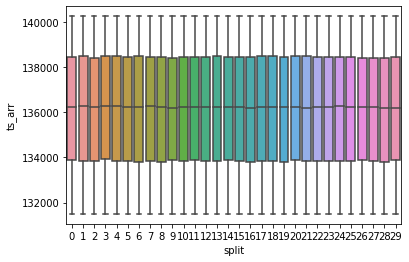

In [12]:
sns.boxplot(x="split", y="ts_arr", data=df_sdg)

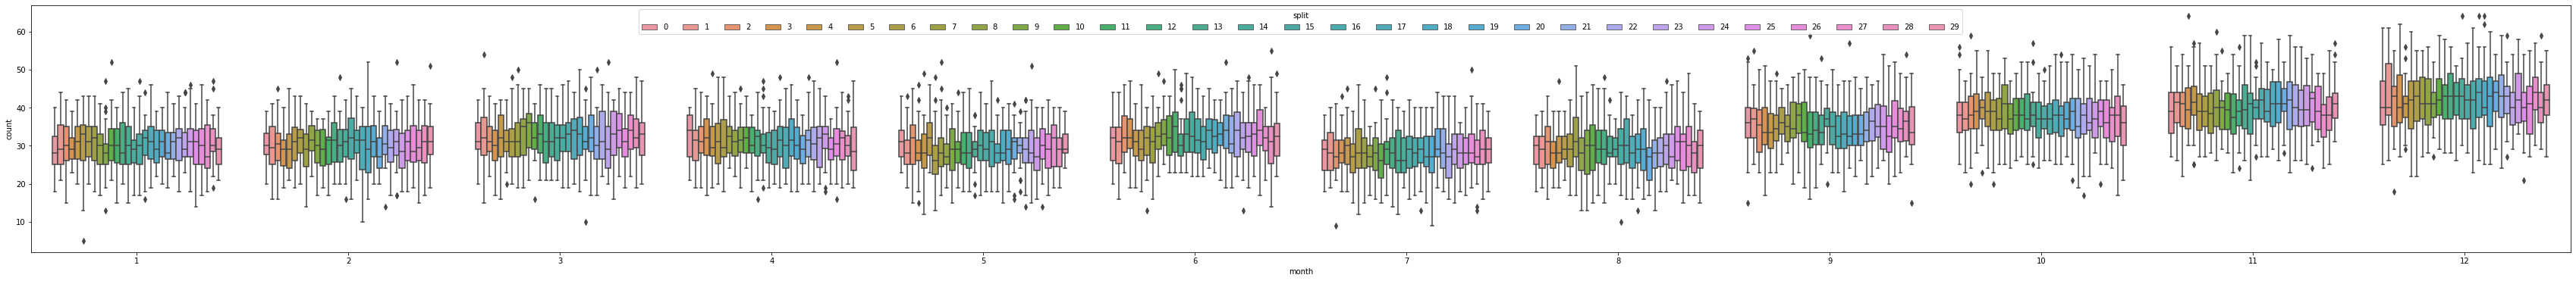

In [13]:
count_sdg = df_sdg.groupby(["day", "month", "split"]).agg(count = ("idSess", "count")).reset_index()
fig1 = plt.figure(figsize=(60, 6))
ax1 = fig1.add_subplot(111)
sns.boxplot(x="month", y="count", hue = "split",  data=count_sdg, ax = ax1)
sns.move_legend(ax1, "upper center", ncol = 30)
